In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

# Skip. Already crawled in text/*
# crawl(full_url)

https://openai.com/
https://openai.com
https://openai.com/research/gpt-4
https://openai.com/research?models=gpt-4
https://openai.com/research/dall-e-2-pre-training-mitigations
https://openai.com/blog/clip
https://openai.com/research?authors=ilya-sutskever
https://openai.com/research?topics=transfer-learning
https://openai.com/research?authors=sandhini-agarwal
https://openai.com/research?contentTypes=release
https://openai.com/research?authors=alec-radford
https://openai.com/research?topics=supervised-learning
https://openai.com/research?authors=gretchen-krueger
https://openai.com/research/clip#content
https://openai.com/research?authors=jong-wook-kim
https://openai.com/research?topics=contrastive-learning
https://openai.com/research?models=clip
https://openai.com/research?contentTypes=conclusion
https://openai.com/research?models=dall-e-2
https://openai.com/research?authors=alex-nichol
https://openai.com/research/dall-e-2-pre-training-mitigations#content
https://openai.com/research?top

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [83]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv.gz', compression='gzip')
df.head()

/var/folders/cc/fxmbhv9n0jsfkhgv45xhf0800000gs/T/ipykernel_34871/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,careers research scientist safety#content,careers research scientist safety#content. Re...
1,research?authors=henk tillman,research?authors=henk tillman. Research index...
2,research?authors=arthur petron,research?authors=arthur petron. Research inde...
3,research roboschool#content,research roboschool#content. Roboschool Cl...
4,blog dall e 2 update#OpenAI,blog dall e 2 update#OpenAI. DALL·E 2 researc...


<AxesSubplot: >

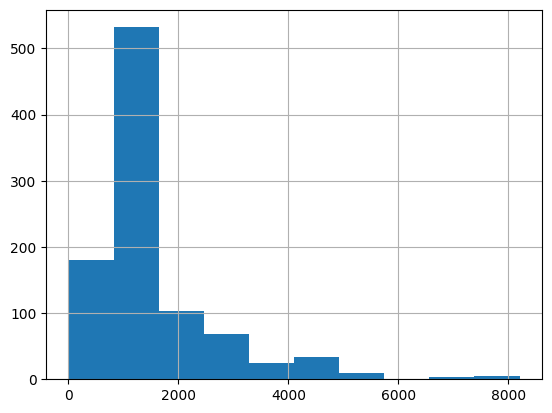

In [27]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv.gz', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [28]:
# Note the original number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 958
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     957 non-null    object
 1   text      959 non-null    object
 2   n_tokens  959 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 30.0+ KB


In [32]:
max_tokens = 2000

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

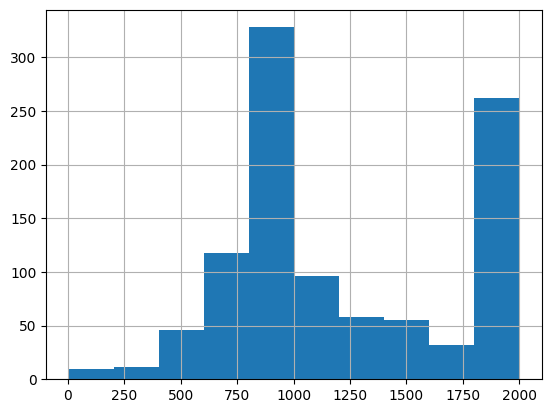

In [33]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [34]:
# More rows after the split
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1016 non-null   object
 1   n_tokens  1016 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ KB


In [26]:
# Look at a sample row with exactly 2000 tokens
with pd.option_context('display.max_colwidth', None):
    print(df[df['n_tokens'] == 2000].head(1).text)

335    blog democratic inputs to ai#ArkaDhar.  Democratic inputs to AI    CloseSearch Submit Skip to main contentSite NavigationResearchOverviewIndexProductOverviewChatGPTGPT-4DALLÂ·E 2Customer storiesSafety standardsPricingDevelopersOverviewDocumentationAPI referenceExamplesSafetyCompanyAboutBlogCareersCharterSecuritySearch Navigation quick links Log inSign upMenu Mobile Navigation CloseSite NavigationResearchProductDevelopersSafetyCompany Quick Links Log inSign upSearch Submit Democratic inputs to AIOur nonprofit organization, OpenAI, Inc., is launching a program to award ten $100,000 grants to fund experiments in setting up a democratic process for deciding what rules AI systems should follow, within the bounds defined by the law.Illustration: Justin Jay WangMay 25, 2023AuthorsWojciech ZarembaArka DharLama AhmadTyna EloundouShibani SanturkarSandhini AgarwalJade LeungAnnouncements,Â Responsible AIAI will have significant, far-reaching economic and societal impacts. Technology shapes 

In [45]:
# Tokenized
tokenizer.encode(df.loc[[335]].text.values[0])

[11921,
 26623,
 11374,
 311,
 16796,
 2,
 7098,
 4657,
 35,
 13279,
 13,
 220,
 11650,
 11374,
 311,
 15592,
 262,
 13330,
 6014,
 30270,
 26869,
 311,
 1925,
 2262,
 18060,
 18464,
 28528,
 42144,
 1581,
 4921,
 42144,
 16047,
 38,
 2898,
 38,
 2898,
 12,
 19,
 35,
 4006,
 33895,
 14260,
 36,
 220,
 17,
 13084,
 7493,
 74137,
 10886,
 47,
 39906,
 21076,
 388,
 42144,
 65434,
 7227,
 5905,
 41481,
 74137,
 14831,
 10714,
 27798,
 33099,
 388,
 4873,
 466,
 15712,
 6014,
 18464,
 4062,
 7902,
 2905,
 304,
 7412,
 709,
 3598,
 13716,
 18464,
 13330,
 18060,
 18464,
 28528,
 4921,
 21076,
 388,
 74137,
 14831,
 17697,
 26496,
 2905,
 304,
 7412,
 709,
 6014,
 30270,
 11650,
 11374,
 311,
 362,
 3895,
 324,
 33184,
 7471,
 11,
 5377,
 15836,
 11,
 4953,
 2637,
 374,
 28818,
 264,
 2068,
 311,
 10292,
 5899,
 400,
 1041,
 11,
 931,
 25076,
 311,
 3887,
 21896,
 304,
 6376,
 709,
 264,
 26623,
 1920,
 369,
 30230,
 1148,
 5718,
 15592,
 6067,
 1288,
 1833,
 11,
 2949,
 279,
 14597,
 4613,


In [53]:
import getpass
import openai
import time


# Enter the API key if empty
openai.api_key = getpass.getpass('Enter your OpenAI API key') if False else openai.api_key


def create_embedding(text):
    embedding = openai.Embedding.create(input=text, engine='text-embedding-ada-002')['data'][0]['embedding']
    time.sleep(1)  # rate limit
    return embedding

# Skip. Embeddings already created in processed/embeddings.csv
# df['embeddings'] = df.text.apply(create_embedding)
# df.to_csv('processed/embeddings.csv.gz', compression='gzip')
# df.head()

,text,n_tokens,embeddings
0,careers research scientist safety#content. Re...,986,"[0.0004623234854079783, -0.02827242948114872, ..."
1,research?authors=henk tillman. Research index...,856,"[-0.007783053908497095, -0.00830866303294897, ..."
2,research?authors=arthur petron. Research inde...,856,"[-0.007406667340546846, -0.006121630780398846,..."
3,research roboschool#content. Roboschool Cl...,1405,"[-0.0026017820928245783, -0.017031095921993256..."
4,blog dall e 2 update#OpenAI. DALL·E 2 researc...,651,"[-0.02009732462465763, -0.017114875838160515, ..."


In [81]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv.gz', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,careers research scientist safety#content. Re...,986,"[0.0004623234854079783, -0.02827242948114872, ..."
1,research?authors=henk tillman. Research index...,856,"[-0.007783053908497095, -0.00830866303294897, ..."
2,research?authors=arthur petron. Research inde...,856,"[-0.007406667340546846, -0.006121630780398846,..."
3,research roboschool#content. Roboschool Cl...,1405,"[-0.0026017820928245783, -0.017031095921993256..."
4,blog dall e 2 update#OpenAI. DALL·E 2 researc...,651,"[-0.02009732462465763, -0.017114875838160515, ..."


In [72]:
# Look at the row again. Note the different values & length.
print(df.loc[[335]].embeddings)
print(len(df.loc[[335]].embeddings.values[0]))

335    [-0.016839521005749702, -0.01593959517776966, ...
Name: embeddings, dtype: object
1536


In [73]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [77]:
answer_question(df, question="What day is it?", debug=True)

Context:
the international.   

###

mission.   

###

scholars.   

###

blog?authors=sam manning.  Blog   CloseSearch Submit Skip to main contentSite NavigationResearchOverviewIndexProductOverviewChatGPTGPT-4DALLÂ·E 2Customer storiesSafety standardsPricingDevelopersOverviewDocumentationAPI referenceExamplesSafetyCompanyAboutBlogCareersCharterSecuritySearch Navigation quick links Log inSign upMenu Mobile Navigation CloseSite NavigationResearchProductDevelopersSafetyCompany Quick Links Log inSign upSearch Submit BlogLatest updates Filter and sort Introducing SuperalignmentJul 5, 2023July 5, 2023Insights from global conversationsJun 29, 2023June 29, 2023Introducing OpenAI LondonJun 28, 2023June 28, 2023Function calling and other API updatesJun 13, 2023June 13, 2023OpenAI cybersecurity grant programJun 1, 2023June 1, 2023Democratic inputs to AIMay 25, 2023May 25, 2023Governance of superintelligenceMay 22, 2023May 22, 2023Introducing the ChatGPT app for iOSMay 18, 2023May 18, 2023New ways

"I don't know."

In [78]:
answer_question(df, question="What is our newest embeddings model?", debug=True)

Context:
blog new and improved embedding model#RyanGreene.  New and improved embedding model    CloseSearch Submit Skip to main contentSite NavigationResearchOverviewIndexProductOverviewChatGPTGPT-4DALLÂ·E 2Customer storiesSafety standardsPricingDevelopersOverviewDocumentationAPI referenceExamplesSafetyCompanyAboutBlogCareersCharterSecuritySearch Navigation quick links Log inSign upMenu Mobile Navigation CloseSite NavigationResearchProductDevelopersSafetyCompany Quick Links Log inSign upSearch Submit New and improved embedding modelWe are excited to announce a new embedding model which is significantly more capable, cost effective, and simpler to use.Quick linksRead documentationIllustration: Ruby ChenDecember 15, 2022AuthorsRyan GreeneTed SandersLilian WengArvind NeelakantanProduct,Â AnnouncementsThe new model, text-embedding-ada-002, replaces five separate models for text search, text similarity, and code search, and outperforms our previous most capable model, Davinci, at most tasks

'The newest embeddings model is text-embedding-ada-002.'

In [79]:
answer_question(df, question="Where are the OpenAI offices?", debug=True)

Context:
blog introducing openai london#OpenAI.  Introducing OpenAI London    CloseSearch Submit Skip to main contentSite NavigationResearchOverviewIndexProductOverviewChatGPTGPT-4DALLÂ·E 2Customer storiesSafety standardsPricingDevelopersOverviewDocumentationAPI referenceExamplesSafetyCompanyAboutBlogCareersCharterSecuritySearch Navigation quick links Log inSign upMenu Mobile Navigation CloseSite NavigationResearchProductDevelopersSafetyCompany Quick Links Log inSign upSearch Submit Introducing OpenAI LondonWe are excited to announce OpenAIâs first international expansion with a new office in London, United Kingdom.Photo: Stuart BaileyJune 28, 2023AuthorsOpenAI Announcements,Â Culture & CareersOur first international office in London signifies a milestone in OpenAIâs growth, showcasing our commitment to broaden the scope of our operations, bring in diverse perspectives, and accelerate our mission of ensuring that artificial general intelligence (AGI) benefits all of humanity.âWe 

'OpenAI has offices in London, United Kingdom and in the United States.'